##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [75]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
# import LSTM
import DenseNet as Dense
# importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [76]:
def Curve(x,a,b,c):
    return (a/(b+x)**c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=iteration)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=iteration)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,iteration,X_fill = X_fill,Memory=Memory),y_val)

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName) 
    
    return(MSE,R2,RST.Master['TempFill'])

In [77]:
FillVar = 'fco2'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge','VWC','Grass']
Runs,params = Dense.Params('Test',FillVar,MP=False)
print(params)

{'proc': 1, 'K': 3, 'epochs': 100, 'Y': 'fco2'}


In [78]:
Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
def RunLoop(Runs):
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(FullModel,params,pool,plot=True)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        print(Runs.loc[Runs['N']==N])
    return(Runs)

Runs = RunLoop(Runs)

   N       MSE        R2
0  4  1.802764  0.796618
1  4  1.649660  0.850325
2  4  3.042750  0.756648
    N       MSE        R2
3  16  1.188323  0.865937
4  16  1.170019  0.893843
5  16  1.157822  0.907400
    N       MSE        R2
6  36  1.078213  0.878359
7  36  1.098959  0.900290
8  36  1.350069  0.892025


# The "Optimum" Sized Model

         MSE        R2        SD        SE
N                                         
4   2.165058  0.801197  0.763949  0.441066
16  1.172055  0.889060  0.015352  0.008864
36  1.175747  0.890225  0.151323  0.087366


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


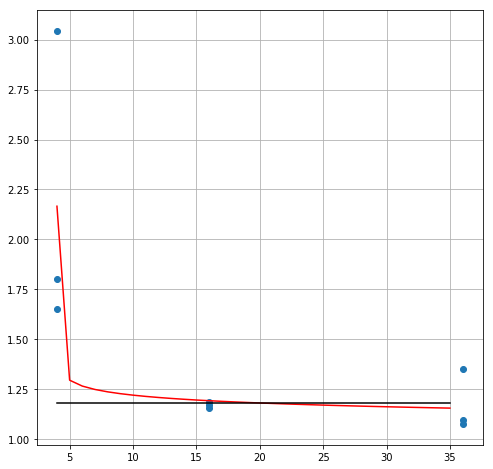

21 1.1809183360144258
109.81743335723877


In [79]:

Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
plt.grid()
plt.show()
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'],Max)
print(time.time()-Time)

# Feature Identification

In [80]:
Scores = Runs[['MSE','R2']].reset_index(drop=True)
Scores = (Scores.iloc[0:params['K']])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)

Results = RunReps(FullModel,params,pool)

MSE = Results[0]
R2 = Results[1]
# mean,std = np.asanyarray(MSE).mean(),np.asanyarray(MSE).std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
Scores['MSE']=Results[0]#MSE#mean
Scores['R2']=Results[1]#R2#.mean()

ModelRuns = Results[2]
ModelRuns = ModelRuns.to_frame()
ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
ModelRuns=ModelRuns.drop('TempFill',axis=1)
print(Scores)

        MSE        R2  Level  Key                               Model
0  1.153083  0.869913      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  1.181437  0.892807      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  1.310439  0.895194      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass


In [81]:
for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
        score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
        Scores = Scores.append(score,ignore_index=True)
        print(Scores.loc[Scores['Key']==key])
        ModelRuns['Model: '+'+'.join(model)] = Results[2]    
    Group = Scores.groupby('Key').agg({'Model': 'first', 
                                            'Level': 'first', 
                                            'MSE': 'mean', 
                                            'R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    print(Best)
    

Level:  1


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


   Key  Level       MSE     Model        R2
3  1_0      1  1.221382  PPFD_Avg  0.862208
4  1_0      1  1.500251  PPFD_Avg  0.863881
5  1_0      1  1.744101  PPFD_Avg  0.860511
   Key  Level        MSE      Model        R2
6  1_1      1  11.087158  AirTC_Avg -0.250817
7  1_1      1   9.018976  AirTC_Avg  0.181700
8  1_1      1  10.584114  AirTC_Avg  0.153509
    Key  Level        MSE  Model        R2
9   1_2      1  10.211797  Sedge -0.152062
10  1_2      1  10.855383  Sedge  0.015081
11  1_2      1  12.539772  Sedge -0.002900
    Key  Level        MSE Model        R2
12  1_3      1  10.033577   VWC -0.131955
13  1_3      1  11.094243   VWC -0.006591
14  1_3      1  12.689070   VWC -0.014841
    Key  Level        MSE  Model        R2
15  1_4      1   9.633015  Grass -0.086765
16  1_4      1  10.995320  Grass  0.002385
17  1_4      1  12.693998  Grass -0.015235
['PPFD_Avg']
Level:  2
    Key  Level       MSE               Model        R2
18  2_0      2  1.334227  PPFD_Avg+AirTC_Avg  0.84

                                  Model  Level       MSE        R2        SD  \
Key                                                                            
1_0                            PPFD_Avg      1  1.488578  0.862200  0.261555   
2_3                      PPFD_Avg+Grass      2  1.500499  0.860387  0.219295   
3_0            PPFD_Avg+AirTC_Avg+Grass      3  1.455911  0.865620  0.290475   
4_1        PPFD_Avg+AirTC_Avg+VWC+Grass      4  1.361037  0.873529  0.194068   
5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5  1.214986  0.885972  0.083871   

           SE  
Key            
1_0  0.151009  
2_3  0.126610  
3_0  0.167706  
4_1  0.112045  
5_0  0.048423  
                                Model  Level       MSE        R2        SD  \
4  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5  1.214986  0.885972  0.083871   

         SE  
4  0.048423  


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


   N       MSE        R2
0  4  1.802941  0.796598
1  4  1.650275  0.850269
2  4  3.048741  0.756169
    N       MSE        R2
3  16  1.188556  0.865911
4  16  1.169969  0.893848
5  16  1.158102  0.907378
    N       MSE        R2
6  36  1.078401  0.878338
7  36  1.098936  0.900293
8  36  1.350941  0.891955
         MSE        R2        SD        SE
N                                         
4   2.165058  0.801197  0.763949  0.441066
16  1.172055  0.889060  0.015352  0.008864
36  1.175747  0.890225  0.151323  0.087366
21


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


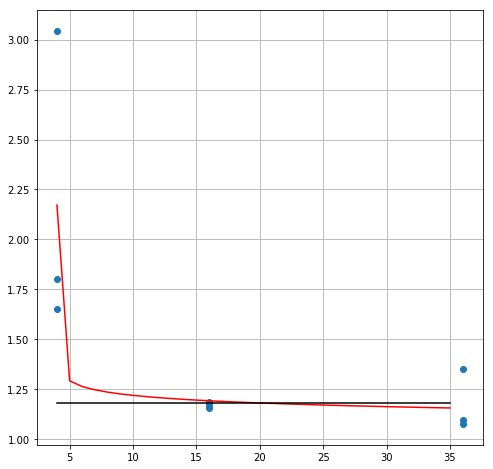

21


In [82]:
Group = Scores.groupby('Key').agg({'Model': 'first', 
                                        'Level': 'first', 
                                        'MSE': 'mean', 
                                        'R2': 'mean'})#.reset_index()#mean()  
Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
Min = Group.loc[Group['Level']==level]

Levels = Group.groupby('Level').min()
Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
print(Sub)
Sub.sort_values('Level',inplace=True)
Sub = Sub.loc[Sub['Level']>=1]
Sub.reset_index(inplace=True,drop=True)
Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
print(Parsimony)
Best = Parsimony['Model'].values

def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N

model = Best[0].split('+')
NRuns = RunLoop(NRuns)
Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

N = np.arange(NRuns['N'].min(),NRuns['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'])
plt.grid()
plt.show()
print(params['N'])

In [83]:
level = 0#len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool)
MSE = Results[0]
# for mse in MSE:
#     Names.append(Name)
#     Values.append(mse)
# mean,std = MSE.mean(),MSE.std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
R2 = Results[1]
d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
Scores = Scores.append(score,ignore_index=True)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
print(params['N'])
print(Scores)

['PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass']
21
     Key  Level        MSE                               Model        R2
0    5_0      5   1.153083  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.869913
1    5_0      5   1.181437  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.892807
2    5_0      5   1.310439  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.895194
3    1_0      1   1.221382                            PPFD_Avg  0.862208
4    1_0      1   1.500251                            PPFD_Avg  0.863881
5    1_0      1   1.744101                            PPFD_Avg  0.860511
6    1_1      1  11.087158                           AirTC_Avg -0.250817
7    1_1      1   9.018976                           AirTC_Avg  0.181700
8    1_1      1  10.584114                           AirTC_Avg  0.153509
9    1_2      1  10.211797                               Sedge -0.152062
10   1_2      1  10.855383                               Sedge  0.015081
11   1_2      1  12.539772                               Sedge -0.002900
12   1_3 

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [84]:
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

748.2673988342285
